# Activated Labours: data analysis and time series
The purpose of this notebook is to have an initial view of the data contained in the **Rapporti_di_lavoro_attivati**.
The objective of this study is to have an initial understanding of eventually founded trends over number of activated labours during the past time.
Next steps will be to add more deep analysis about time and some particular features that are present in the dataset. 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import utils

STD_SIZE = (15, 10)
MID_SIZE = (25, 20)
BIG_SIZE = (30, 30)

### Study on dataset **Activated Labours**

In [29]:
!ls

activated_labours.ipynb  Rapporti_di_lavoro_attivati.csv
ceased_labours.ipynb	 Rapporti_di_lavoro_cessati.csv
__pycache__		 utils.py


In [30]:
activated_labours = pd.read_csv('Rapporti_di_lavoro_attivati.csv')
activated_labours.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,09/05/2020,F,60,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA
1,12/07/2019,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
2,05/06/2013,F,20,Fabbricazione di altre apparecchiature elettri...,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,12/03/2010,F,28,Alberghi,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE A TEMPO DETERMINATO,NON DEFINITO,BERGAMO,ITALIA
4,06/04/2021,F,49,Rifugi di montagna,LICENZA MEDIA,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA


### Print of categorical data distributions

N.B.: this cell takes about 2 mins to execute

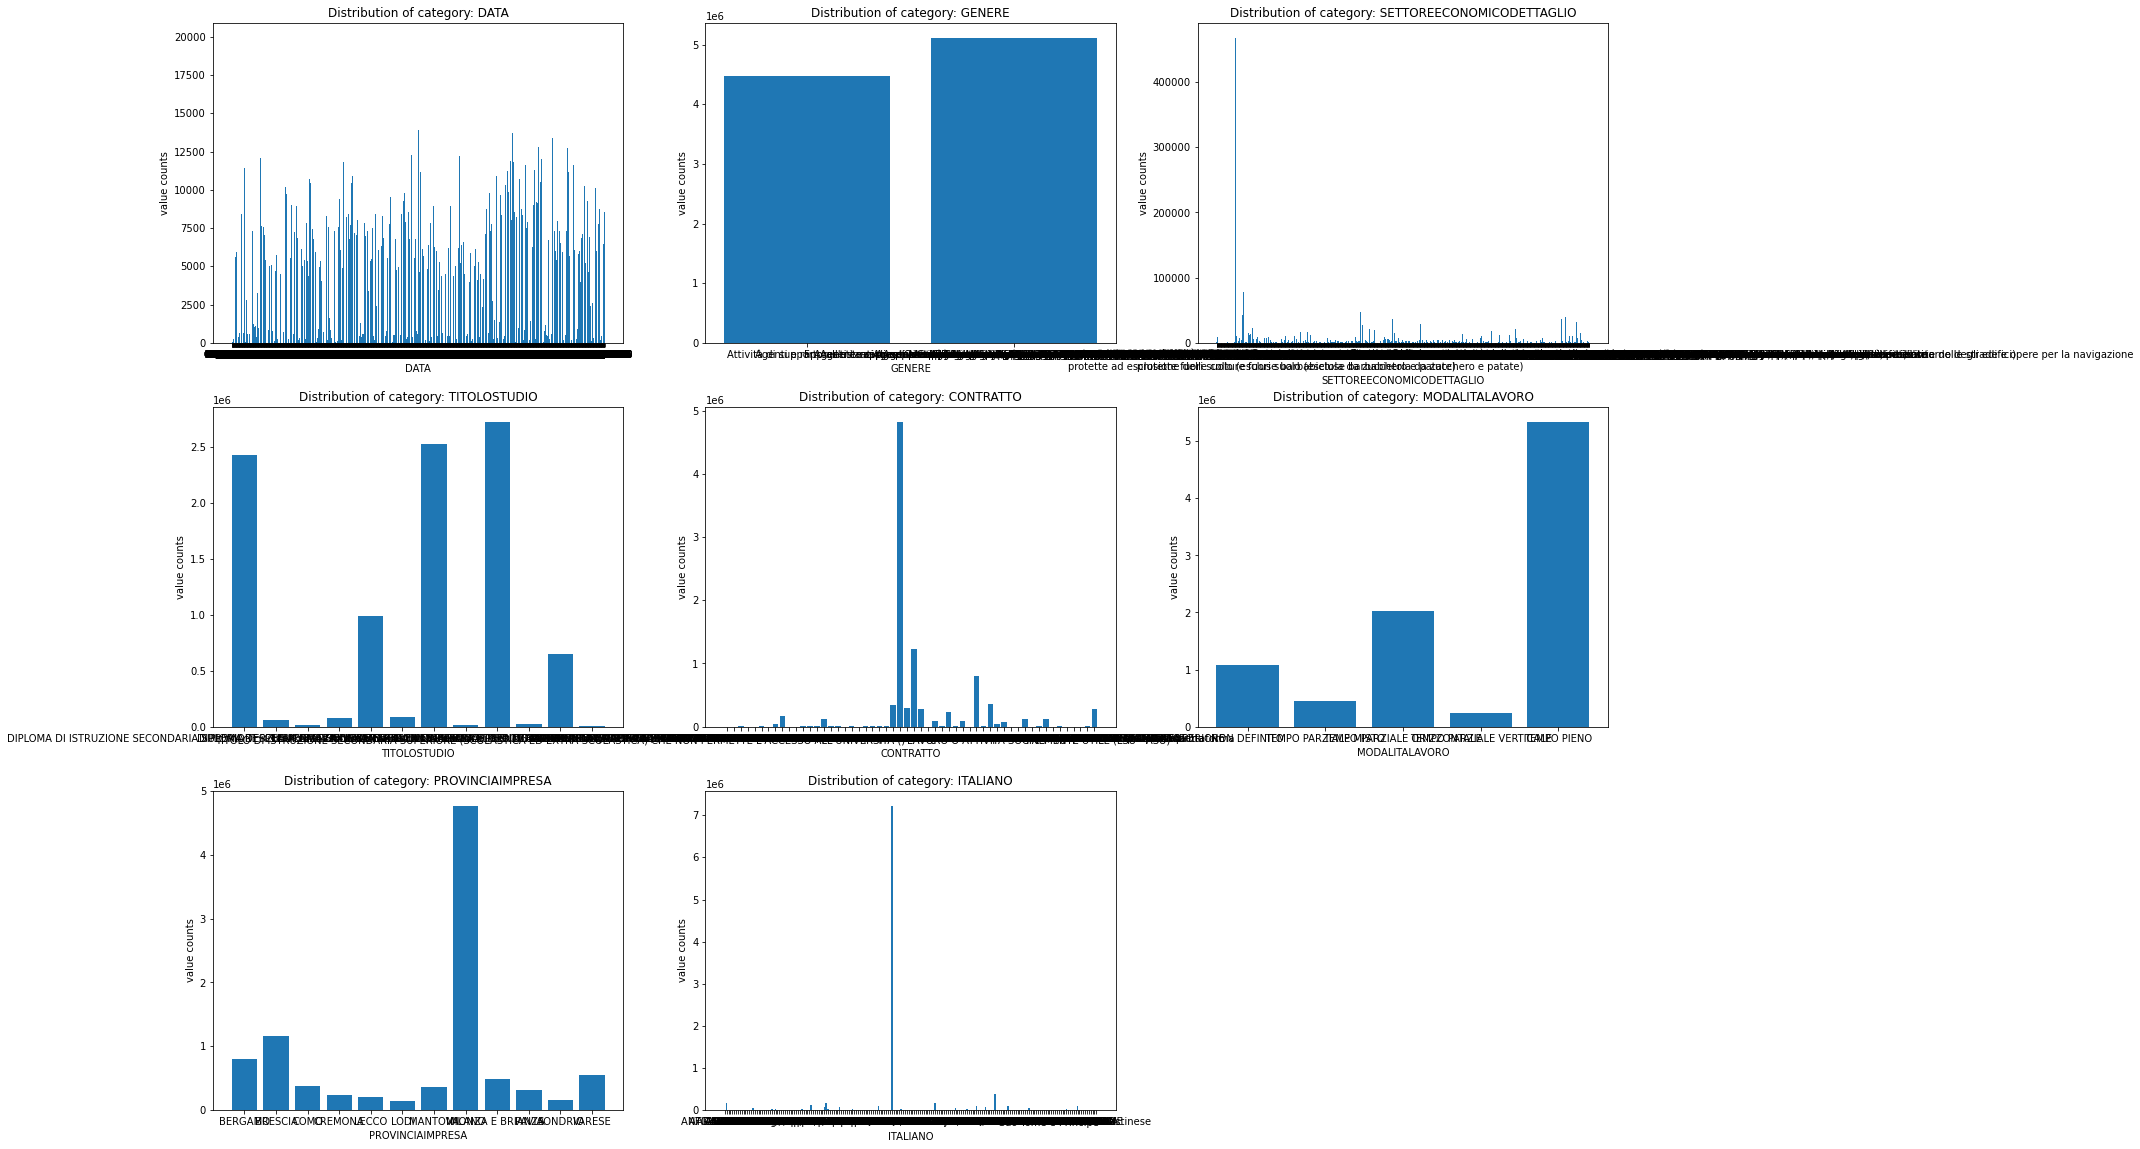

In [ ]:
categorical_features = [col for col in activated_labours if activated_labours[col].dtype == 'object']

fig = plt.figure(figsize=MID_SIZE)
for i, category in enumerate(categorical_features):
    ax = fig.add_subplot(3, 3, i+1)
    plt.bar(x=activated_labours.groupby(category).count().index, height=[counts[0] for counts in activated_labours.groupby(category).count().values])
    ax.set_title('Distribution of category: %s' % category)
    ax.set_xlabel(category)
    ax.set_ylabel('value counts')
plt.show()

In [31]:
len(activated_labours)

9579794

### Sort records basing on DATA column

Convert values into DATA column into datetime objects.
This step is mainly required for time series analysis started at the end of the notebook.

In [32]:
activated_labours['DATA'] = pd.to_datetime(activated_labours['DATA'])

In [33]:
activated_labours['DATA'].head()

0   2020-09-05
1   2019-12-07
2   2013-05-06
3   2010-12-03
4   2021-06-04
Name: DATA, dtype: datetime64[ns]

Sort basing on dates

In [34]:
activated_labours = activated_labours.sort_values(by='DATA', ascending=True)
activated_labours.reset_index(drop=True, inplace=True)
min_ok = activated_labours.DATA.min() == activated_labours.DATA[0]
max_ok = activated_labours.DATA.max() == activated_labours.DATA[len(activated_labours) - 1]
print('Sorted' if min_ok and max_ok else 'Not sorted')

Sorted


## Inspection of null values

In [35]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 9 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6
SETTOREECONOMICODETTAGLIO,2888,0.0
TITOLOSTUDIO,580,0.0


Only three columns contains null values... Let's inspect more deeply how could i remove them.

### TITOLO DI STUDIO

In [36]:
activated_labours.loc[:, ['TITOLOSTUDIO']].value_counts()

TITOLOSTUDIO                                                                                                           
NESSUN TITOLO DI STUDIO                                                                                                    2721891
LICENZA MEDIA                                                                                                              2523342
DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA                                          2430781
LAUREA - Vecchio o nuovo ordinamento                                                                                        988171
TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()     645228
LICENZA ELEMENTARE                                                                                                           82570
DIPLOMA UNIVERSITARIO                                                                         

I'll fill in all the null values in the **TITOLO DI STUDIO** column with the **NESSUN TITOLO DI STUDIO** value

In [37]:
activated_labours.TITOLOSTUDIO.fillna('NESSUN TITOLO DI STUDIO', inplace=True)

In [38]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 9 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6
SETTOREECONOMICODETTAGLIO,2888,0.0


### SETTORE ECONOMICO DETTAGLIO

In [39]:
counts = activated_labours.loc[:, ['SETTOREECONOMICODETTAGLIO']].value_counts()
counts

SETTOREECONOMICODETTAGLIO                                                                                                                                                      
Alberghi                                                                                                                                                                           467057
Ristorazione con somministrazione                                                                                                                                                  445191
Attività di produzione cinematografica, di video e di programmi televisivi                                                                                                         379116
Attività di famiglie e convivenze come datori di lavoro per personale domestico                                                                                                    348181
Altri servizi di supporto alle imprese nca                                      

<BarContainer object of 18 artists>

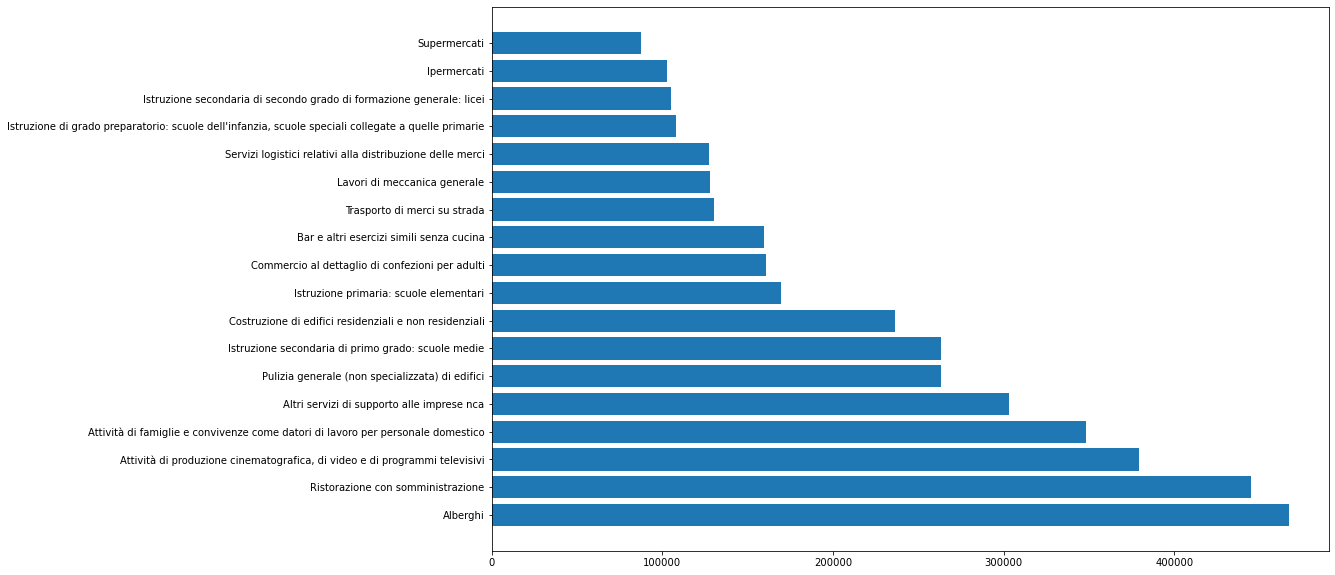

In [40]:
LIMIT = 80000
counts = counts[counts.values > LIMIT]
plt.figure(figsize=STD_SIZE)
plt.barh(y=[i[0] for i in counts.index], width=counts.values)

Column **settore economico dettaglio** contains too general information and not enough useful concerning our study. In order to make an understandable plot i would have to avoid considering too many values, so for now i'll drop it.

In [41]:
activated_labours.drop(labels=['SETTOREECONOMICODETTAGLIO'], axis=1, inplace=True)

In [42]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6


### MODALITA LAVORO

In [43]:
activated_labours.loc[:, ['MODALITALAVORO']].value_counts()

MODALITALAVORO            
TEMPO PIENO                   5337940
TEMPO PARZIALE ORIZZONTALE    2026056
NON DEFINITO                  1087460
TEMPO PARZIALE MISTO           445419
TEMPO PARZIALE VERTICALE       242140
dtype: int64

Fill null values into **modalità lavoro** with value **NON DEFINITO**

In [44]:
activated_labours['MODALITALAVORO'] = activated_labours['MODALITALAVORO'].fillna('NON DEFINITO')
activated_labours['MODALITALAVORO'].isnull().sum()

0

In [45]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Now the dataframe contains **0** null values.

### Rename column **italiano** into **nazionalita**

In [46]:
activated_labours.rename({'ITALIANO': 'NAZIONALITA'}, axis=1, inplace=True)

# Duplicated records

In [47]:
activated_labours.duplicated().sum()

2536002

the presence of duplicated lines is not meaningful because there could be different people with same characteristics having activated a labour in the same day

## Descriptive statistics

The following function prints some useful measures of variability in order to have a clearer understanding of the **ETA** column, which is the only column that contains numerical values.

In [48]:
utils.variability_measures(activated_labours, column='ETA')

Mean on column ETA: 35.301741457070996
Median on column ETA: 34.0
Mode on column ETA: 0    25
Name: ETA, dtype: int64
Variance on column ETA: 138.82357821373805
Standard deviation on column ETA: 11.78234179667769
Mean absolute deviation on column ETA: 9.849852522936677
Median absolute deviation on column ETA: 9.768722688608962


# Time series analysis

In this part i will try to find out some patters, autocorrelations and seasonalities

Firstly let's set the data column as index

In [49]:
activated_labours.set_index('DATA', inplace=True)
activated_labours.head()

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA
DATA,,,,,,,
1973-02-01,F,20,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
1974-11-06,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
1976-01-10,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
1978-01-05,M,25,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA
1978-10-07,M,26,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA


Then count the number of records belonging to each month in all the years in the dataset.

In [50]:
num_monthly = activated_labours.groupby(activated_labours.index.month).count().iloc[:, [0]]
num_monthly

,GENERE
DATA,
1,758272
2,774982
3,727018
4,716190
5,716028
6,781226
7,805486
8,684845
9,1149358


<AxesSubplot:title={'center':'Monthly total number of activated labours'}, xlabel='Month', ylabel='Number of activated labours'>

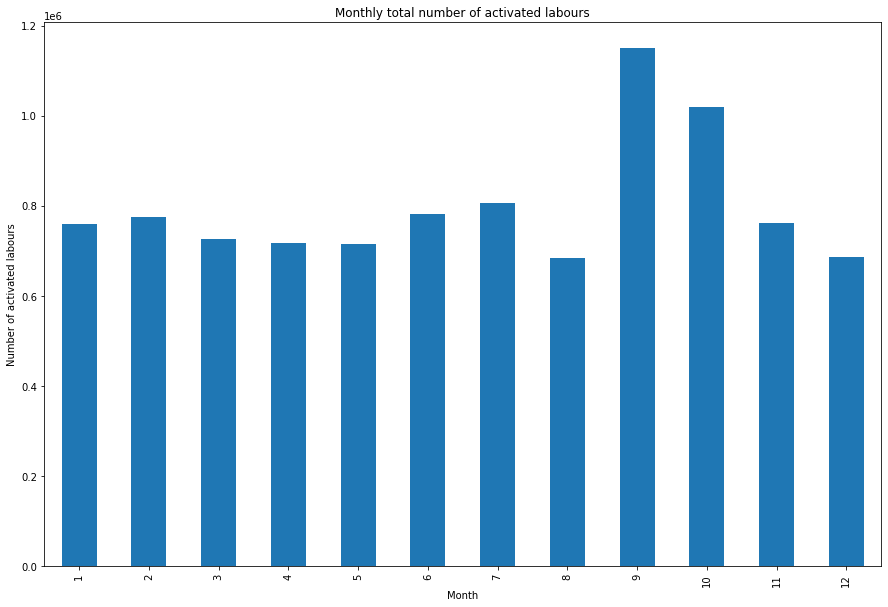

In [51]:
num_monthly.plot(title='Monthly total number of activated labours', 
                 xlabel='Month', 
                 ylabel='Number of activated labours', 
                 kind='bar', 
                 legend=False, 
                 figsize=STD_SIZE)

It seems that August and December, probably due to vacations, are the months during which there are less activations of labours, while the higher number of activations are achieved during September and October.

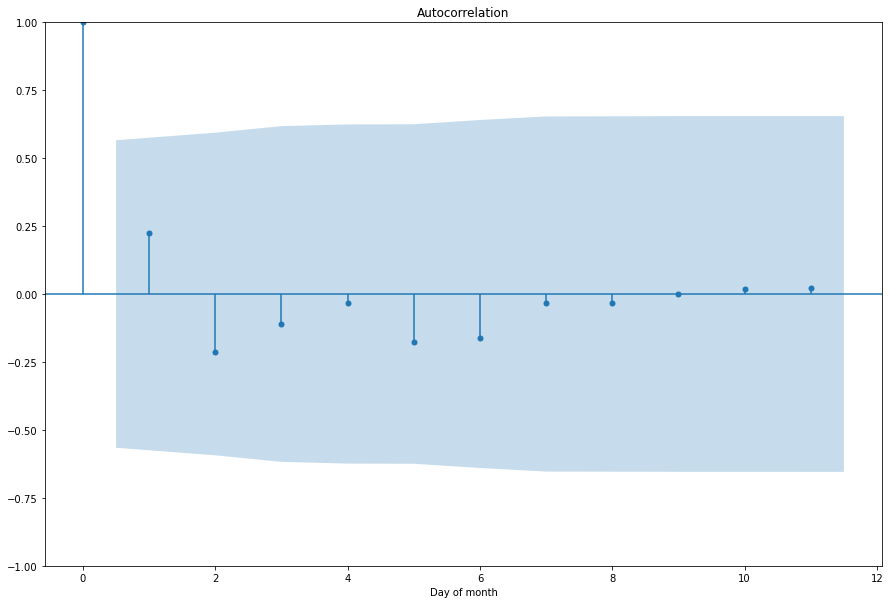

In [53]:
plt.rc('figure', figsize=STD_SIZE)
plot_acf(activated_labours.groupby(activated_labours.index.month).count().iloc[:,[0]])
plt.xlabel('Day of month')
plt.show()

Autocorrelation shows if there are correlations between current data and the same data in the past. The trend of the above plot shows that is a lack of autocorrelation between months of the same year. This means that number of activated labours aren't likely to have the same trend during the months of every year.

...from now on is work in progress

In [ ]:
num_monthly2 = activated_labours.groupby([activated_labours.index.month, 'CONTRATTO']).count().iloc[:,[0]]
num_monthly2 = num_monthly2.unstack('CONTRATTO')
num_monthly2

GENERE  \
CONTRATTO APPRENDISTATO DI ALTA FORMAZIONE E RICERCA   
DATA                                                   
1                                               83.0   
2                                               72.0   
3                                               43.0   
4                                               51.0   
5                                               56.0   
6                                               55.0   
7                                               27.0   
8                                               31.0   
9                                               72.0   
10                                              72.0   
11                                              40.0   
12                                              68.0   

                                                                                  \
CONTRATTO APPRENDISTATO DI ALTA FORMAZIONE E RICERCA PER LAVORATORI IN MOBILITA¿   
DATA                                                                               
1                                                        NaN                       
2                                                        NaN                       
3                                                        NaN                       
4                                                        NaN                       
5                                                        NaN                       
6                                                        1.0                       
7                                                        NaN                       
8                                                        NaN                       
9                                                        NaN                       
10                                                       NaN                       
11                                                       NaN                       
12                                                       NaN                       

                                             \
CONTRATTO APPRENDISTATO EX ART.16 L. 196/97   
DATA                                          
1                                     455.0   
2                                     700.0   
3                                     634.0   
4                                     577.0   
5                                     473.0   
6                                     976.0   
7                                    1265.0   
8                                     425.0   
9                                    1137.0   
10                                    979.0   
11                                    746.0   
12                                    398.0   

                                                                                         \
CONTRATTO APPRENDISTATO PER L'ACQUISIZIONE DI DIPLOMA O PER PERCORSI DI ALTA FORMAZIONE   
DATA                                                                                      
1                                                       12.0                              
2                                                       15.0                              
3                                                        2.0                              
4                                                        5.0                              
5                                                        1.0                              
6                                                        7.0                              
7                                                        4.0                              
8                                                        4.0                              
9                                                       17.0                              
10                                                       7.0                              
11                                                     